In [14]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
#train data load for 6000000 rows
train = pd.read_csv('C:/System Simulation/Project/E_Data/train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


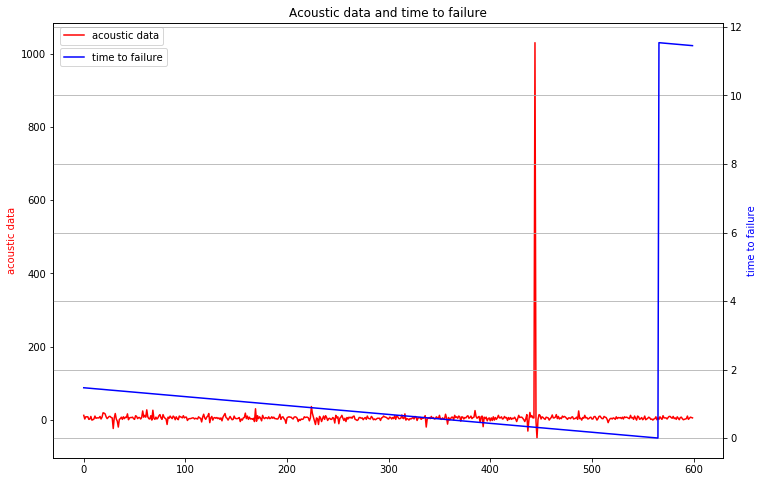

In [35]:
#Acoustic data and time to failure visualization
train_ad_sample_df = train['acoustic_data'].values[::10000]
train_ttf_sample_df = train['time_to_failure'].values[::10000]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)

In [4]:
#function for features engineering
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [5]:
#features engineering on training data
train = pd.read_csv('C:/System Simulation/Project/E_Data/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))


In [6]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [9]:
#features engineering on testing data of segment seg_fdd50e
test = pd.read_csv('C:/System Simulation/Project/E_Data/seg_fdd50e.csv',iterator=True, dtype={'acoustic_data': np.int16})
X_test = pd.DataFrame()
for df in test:
    ch = gen_features(df['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)


In [28]:
#CatBoost Model
train_pool = Pool(X_train, y_train)
m_cat = CatBoostRegressor(iterations=1000, loss_function='MAE', boosting_type='Ordered')
m_cat.fit(X_train, y_train, silent=True)

y_pred = m_cat.predict(X_train)
MAE_Cat = mean_absolute_error(y_train,y_pred)
MAE_Cat

2.0583223063713367

In [12]:
#SVR Model
from sklearn.svm import  SVR
grid_hyperparameter = [{'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

clf_SVR = GridSearchCV(SVR(kernel='rbf', tol=0.01), grid_hyperparameter, cv=5, scoring='neg_mean_absolute_error')
clf_SVR.fit(X_train, y_train)
clf_c = clf_SVR.best_estimator_.get_params()['C']

m_SVR = SVR(kernel='rbf', tol=0.01,C = clf_c)
m_SVR.fit(X_train, y_train)

y_pred = clf_SVR.predict(X_train)
MAE_SVR = mean_absolute_error(y_train,y_pred)
MAE_SVR

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

1.351536805736116

In [16]:
#Linear Regression Model
Grid_Parameters = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

m_linear = GridSearchCV(SGDRegressor(loss = "squared_loss", penalty = "l2"),Grid_Parameters,cv =5)
m_linear.fit(X_train, y_train)
alpha = m_linear.best_params_["alpha"]

m_linear = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
m_linear.fit(X_train, y_train)

y_pred = m_linear.predict(X_train)
MAE_Linear = mean_absolute_error(y_train,y_pred)
MAE_Linear

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 a

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 a

7561936098491.705

In [17]:
#Random Forest Model
grid_hyperparameter = [{'n_estimators'  : [10,20,30],'max_depth':[5,10]}]

RFM = GridSearchCV(RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3), grid_hyperparameter, cv=2)
RFM.fit(X_train, y_train)

clf_nr = RFM.best_estimator_.get_params()['n_estimators']
clf_depthr = RFM.best_estimator_.get_params()['max_depth']

clf_RF = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=clf_nr,max_depth = clf_depthr)
clf_RF.fit(X_train, y_train)

y_pred = clf_RF.predict(X_train)
MAE_RF = mean_absolute_error(y_train,y_pred)
MAE_RF

2.0828838313086004

In [30]:
#Comaparison
from prettytable import PrettyTable
    
Table = PrettyTable()

Table.field_names  = ["Model","Mean Absolute Error"]
Table.add_row(["CatBoost Model",MAE_Cat])
Table.add_row(["SVR Model",MAE_SVR])
Table.add_row(["Linear Regression Model", MAE_Linear])
Table.add_row(["Random Forest Model",MAE_RF])

print(Table)

+-------------------------+---------------------+
|          Model          | Mean Absolute Error |
+-------------------------+---------------------+
|      CatBoost Model     |  2.0583223063713367 |
|        SVR Model        |  1.351536805736116  |
| Linear Regression Model |  7561936098491.705  |
|   Random Forest Model   |  2.0828838313086004 |
+-------------------------+---------------------+


# So SVR is the Best Model to predict more acurately that when earthqauke will occur.

In [34]:
#Predict the Earthquake time of segment id seg_fdd50e
m_SVR = SVR(kernel='rbf', tol=0.01,C = clf_c)
m_SVR.fit(X_train, y_train)

y_pred = clf_SVR.predict(X_test)
y_pred[0:1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([5.01668785])

# Earthquae will occur after 5.01668785 second for segment id seg_fdd50e